In [1]:
import logging
import numpy
import numpy as np
import pandas as pd
from math import *
from datetime import datetime
from operator import itemgetter
from zipfile import ZipFile
from io import BytesIO
import pickle
from urllib.request import urlopen

from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from numpy import inf
from scipy.stats import kurtosis, skew

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import average_precision_score
from sklearn.metrics import mean_squared_error



import warnings
warnings.filterwarnings('ignore')

from functions import *
from fair_func import *

In [2]:
from pandas.api.types import CategoricalDtype

In [3]:
import analyser as ans

In [4]:
#!pip install pdpbox
from pdpbox import pdp, get_dataset, info_plots

#!pip install PyALE
from PyALE import ale

In [8]:
data = pd.read_csv('RAIdata.csv')

In [9]:
data.shape

(61321, 206)

In [10]:
data["Default"].value_counts()

0.0    46752
1.0    14569
Name: Default, dtype: int64

<div class="alert alert-block alert-success">
<b>Inference:</b>
We can infer that the data has more 0's (False) when it comes to defaulter compared to 1's (True).  
Thus there are more non-defaulters than defaulters.
</div>

In [11]:
datatest=data

In [12]:
datatest['MonthlyPayment'].fillna((datatest['MonthlyPayment'].mean()), inplace=True)
datatest['ExpectedLoss'].fillna((datatest['ExpectedLoss'].mean()), inplace=True)
datatest['ProbabilityOfDefault'].fillna((datatest['ProbabilityOfDefault'].mean()), inplace=True)
datatest['DebtToIncome'].fillna((datatest['DebtToIncome'].mean()), inplace=True)
datatest['FreeCash'].fillna((datatest['FreeCash'].mean()), inplace=True)
datatest['LossGivenDefault'].fillna(0, inplace=True)

In [13]:
target=['Default']

In [14]:
x=datatest.drop(columns=['Age', 'Default'])
y=datatest['Default']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=6699)

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, random_state=0)

In [17]:
pred_0 = clf.predict_proba(X_test)[:,1]
pred_0

array([0.34142748, 0.17957637, 0.18169739, ..., 0.18670926, 0.34768952,
       0.16745775])

In [18]:
f_imp = pd.Series(clf.feature_importances_, index=X_train.columns)
f_imp = pd.DataFrame(f_imp, columns=['coeff'])
f_imp = f_imp.reset_index()
f_imp = f_imp.sort_values('coeff', ascending=False)

In [19]:
X_test.shape

(18397, 204)

In [20]:
top20=f_imp['index'][:20].to_list()

In [21]:
top20df=datatest.loc[:,top20]

In [24]:
top20df.dtypes

OccupationArea_-1.0              int64
FreeCash                       float64
MaritalStatus_4.0                int64
DebtToIncome                   float64
EmploymentStatus_3.0             int64
IncomeFromPrincipalEmployer    float64
EmploymentStatus_1.0             int64
Unnamed: 0                       int64
ExpectedLoss                   float64
MonthlyPayment                 float64
LossGivenDefault               float64
UseOfLoan_0                      int64
UseOfLoan_2                      int64
Interest                       float64
Rating_HR                        int64
MaritalStatus_3.0                int64
ProbabilityOfDefault           float64
Education_2.0                    int64
NewCreditCustomer_False          int64
MaritalStatus_2.0                int64
dtype: object

In [25]:
categorical = set((
'OccupationArea_-1.0',       
'MaritalStatus_4.0',
'EmploymentStatus_3.0',            
'EmploymentStatus_1.0',
'MaritalStatus_3.0',                
'NrOfDependants_1',                 
'UseOfLoan_0',                     
'CreditScoreEeMini_1000.0',        
'Rating_HR',                       
'UseOfLoan_7',                      
'UseOfLoan_2',      
))




In [27]:
X_train.columns

Index(['Unnamed: 0', 'AppliedAmount', 'DebtToIncome', 'ExpectedLoss',
       'LiabilitiesTotal', 'FreeCash', 'IncomeFromChildSupport',
       'IncomeFromFamilyAllowance', 'IncomeFromLeavePay', 'IncomeFromPension',
       ...
       'VerificationType_2.0', 'VerificationType_3.0', 'VerificationType_4.0',
       'WorkExperience_10To15Years', 'WorkExperience_15To25Years',
       'WorkExperience_2To5Years', 'WorkExperience_5To10Years',
       'WorkExperience_LessThan2Years', 'WorkExperience_MoreThan25Years',
       'Young'],
      dtype='object', length=204)

In [28]:
X_train[X_train['AppliedAmount'] >= 2300].shape[0]

15661

In [29]:
sensitivity = 1
#epsilon = 0.1

original = X_train[X_train['AppliedAmount'] >= 2300].shape[0]

V=[]
ep=[]
count=[]

for j in range (1,6):
    epsilon = j/10

    for i in range(0, 101):

        value = X_train[X_train['AppliedAmount'] >= 2300].shape[0] + \
        np.random.laplace(loc=0, scale=sensitivity/epsilon)
        V.append(value)
        ep.append(epsilon)
        count.append(i)
        


In [30]:
fra = pd.DataFrame({'Value':V, 'ep':ep, 'count':count})

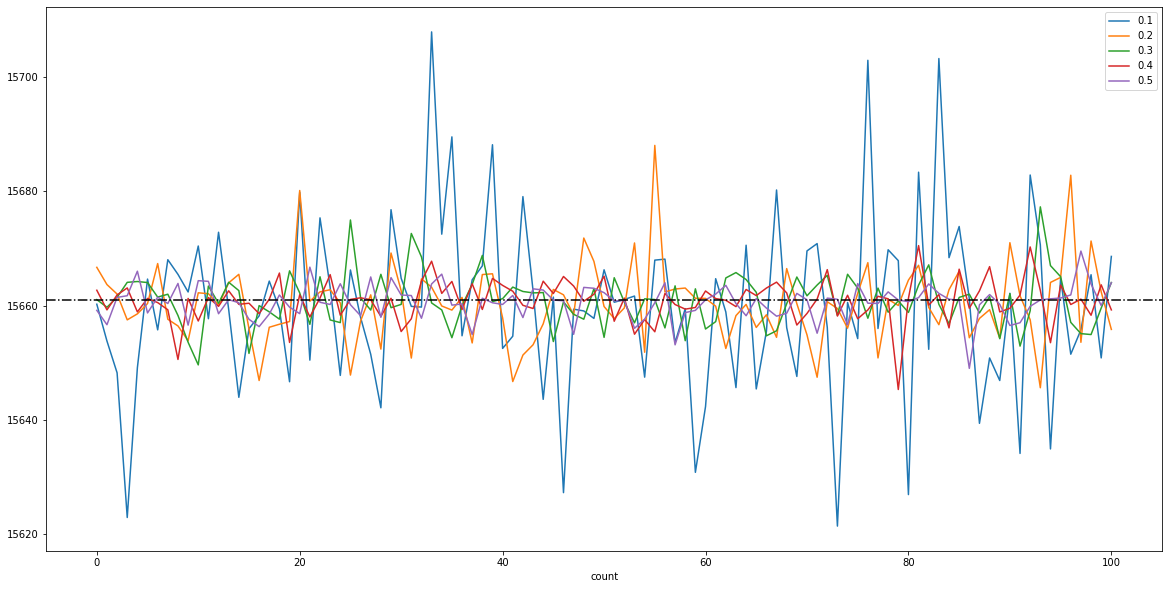

In [31]:
fig, ax = plt.subplots(figsize=(20,10))
for name, group in fra.groupby('ep'):
    group.plot('count', y='Value', ax=ax, label=name)
plt.axhline(y=original, color='black', linestyle='-.')

plt.show()

In [32]:
fra.groupby('ep')['Value'].mean()

ep
0.1    15659.968898
0.2    15660.383647
0.3    15660.931133
0.4    15660.845803
0.5    15660.583351
Name: Value, dtype: float64

In [33]:
fra.groupby('ep')['Value'].mean()/original

ep
0.1    0.999934
0.2    0.999961
0.3    0.999996
0.4    0.999990
0.5    0.999973
Name: Value, dtype: float64

In [34]:
# Mean

In [35]:
sensitivity = ((X_train['AppliedAmount'][X_train['AppliedAmount'] >= 2300]).max())/(len(X_train)+1)
print(sensitivity)
#epsilon = 0.1

original = (X_train['AppliedAmount'][X_train['AppliedAmount'] >= 2300]).mean()

V=[]
ep=[]
count=[]

for j in range (1,6):
    epsilon = j/10

    for i in range(0, 101):

        noised = (X_train['AppliedAmount'][X_train['AppliedAmount'] >= 2300]).mean() + \
        np.random.laplace(loc=0, scale=sensitivity/epsilon)
        value=noised
        V.append(value)
        ep.append(epsilon)
        count.append(i)
        


0.24764123471170646


In [36]:
fra = pd.DataFrame({'Value':V, 'ep':ep, 'count':count})

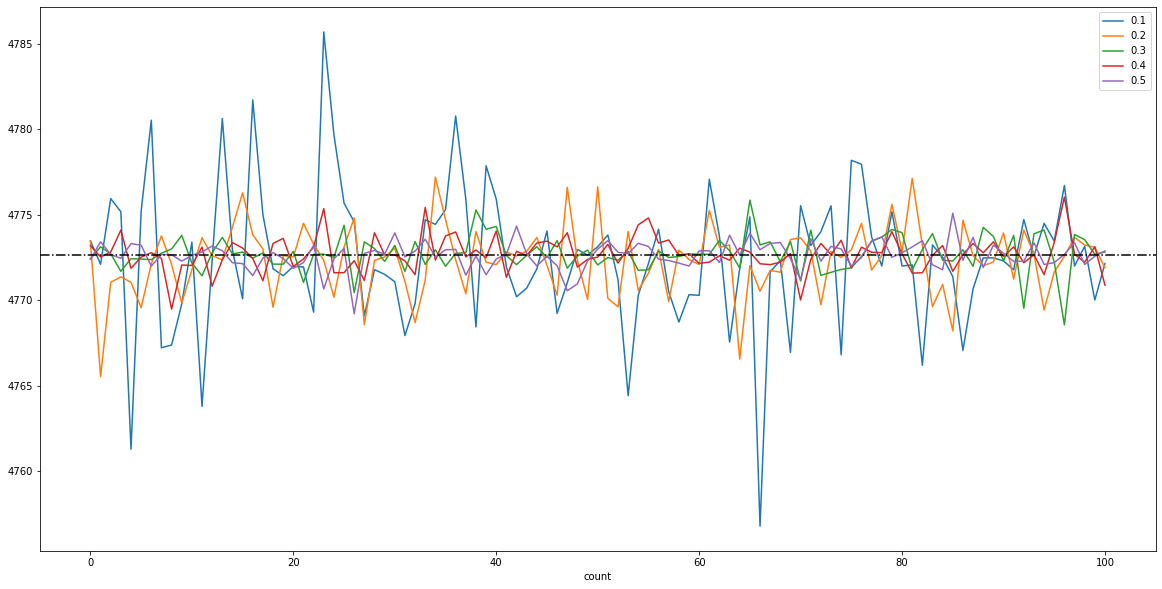

In [37]:
fig, ax = plt.subplots(figsize=(20,10))
for name, group in fra.groupby('ep'):
    group.plot('count', y='Value', ax=ax, label=name)
plt.axhline(y=original, color='black', linestyle='-.')

plt.show()

In [38]:
fra.groupby('ep')['Value'].mean()

ep
0.1    4772.440009
0.2    4772.321765
0.3    4772.715844
0.4    4772.703855
0.5    4772.627765
Name: Value, dtype: float64

In [39]:
fra.groupby('ep')['Value'].mean()/original

ep
0.1    0.999957
0.2    0.999933
0.3    1.000015
0.4    1.000013
0.5    0.999997
Name: Value, dtype: float64

# Exponential mech

In [45]:
data.columns

Index(['Unnamed: 0', 'Age', 'AppliedAmount', 'DebtToIncome', 'ExpectedLoss',
       'LiabilitiesTotal', 'FreeCash', 'IncomeFromChildSupport',
       'IncomeFromFamilyAllowance', 'IncomeFromLeavePay',
       ...
       'VerificationType_2.0', 'VerificationType_3.0', 'VerificationType_4.0',
       'WorkExperience_10To15Years', 'WorkExperience_15To25Years',
       'WorkExperience_2To5Years', 'WorkExperience_5To10Years',
       'WorkExperience_LessThan2Years', 'WorkExperience_MoreThan25Years',
       'Young'],
      dtype='object', length=206)

In [49]:
def undummy(d):
    return d.columns[d.values.argmax(1)]

data2 = data.assign(Rating=data.filter(regex='^Rating').pipe(undummy))

In [50]:
data2['Rating'].value_counts()/data2.shape[0]

Rating_C     0.233346
Rating_D     0.196083
Rating_B     0.187489
Rating_E     0.162457
Rating_A     0.125063
Rating_AA    0.039807
Rating_F     0.031996
Rating_HR    0.023760
Name: Rating, dtype: float64

In [52]:
data2= data2.dropna(subset=['Rating'])

In [53]:
values = data2['Rating'].unique()

In [54]:
def score(data, option):
    return data.value_counts()[option]/(data.shape[0])


def laplace_max(df, values, scoref, sensitivity, epsilon):
    # Calculate the score for each element of R
    scoresf = [scoref(df, val) for val in values]

    lap_noise = [(scoref + np.random.laplace(loc=0, scale=sensitivity/epsilon)) for scoref in scoresf]

    idx = np.argmax(lap_noise)
    
    return values[idx]

In [55]:
[score(data2['Rating'], val) for val in values]

[0.1960829079760604,
 0.23334583584742585,
 0.18748878850638442,
 0.162456580942907,
 0.12506319205492408,
 0.03980691769540614,
 0.031995564325435,
 0.023760212651457085]

In [56]:
laplace_max(data2['Rating'], values, score, 1, 1)

'Rating_D'

In [57]:
r=[laplace_max(data2['Rating'], values, score, 1, 1) for i in range(200)]
pd.Series(r).value_counts()

Rating_D     31
Rating_AA    30
Rating_A     27
Rating_B     26
Rating_E     25
Rating_C     23
Rating_F     21
Rating_HR    17
dtype: int64

In [58]:
j = pd.Series(r).value_counts()
j/j.sum()

Rating_D     0.155
Rating_AA    0.150
Rating_A     0.135
Rating_B     0.130
Rating_E     0.125
Rating_C     0.115
Rating_F     0.105
Rating_HR    0.085
dtype: float64

In [59]:
def exponential(df, values, scoref, sensitivity, epsilon):
    # Calculate the score for each element of R
    scoresf = [scoref(df, val) for val in values]
    
    # Calculate the probability for each element, based on its score
    probabilities = [np.exp(epsilon * scoref / (2 * sensitivity)) for scoref in scoresf]
    
    # Normalize the probabilties so they sum to 1
    probabilities = probabilities / np.linalg.norm(probabilities, ord=1)
    #print(probabilities)

    # Choose an element from R based on the probabilities
    return np.random.choice(values, 1, p=probabilities)[0]
  


In [60]:
exponential(data2['Rating'], values, score, 1, 1)

'Rating_D'

In [61]:
r = [exponential(data2['Rating'], values, score, 1, 1) for i in range(200)]
pd.Series(r).value_counts()

Rating_D     31
Rating_C     28
Rating_B     27
Rating_E     27
Rating_A     25
Rating_F     23
Rating_HR    22
Rating_AA    17
dtype: int64

In [62]:
j = pd.Series(r).value_counts()
j/j.sum()

Rating_D     0.155
Rating_C     0.140
Rating_B     0.135
Rating_E     0.135
Rating_A     0.125
Rating_F     0.115
Rating_HR    0.110
Rating_AA    0.085
dtype: float64